# Endogenous Retirement: A Canonical Discrete-Continuous Problem

This notebook demonstrates a solution to the difficult problem of solving for the optimal retirement date given that consumption and asset choices are continuous.  <cite data-cite="6202365/4F64GG8F"></cite>

The chief complication here is that having more assets might make you consume less, because having more assets increases the probability that you might be able to retire earlier, which would increase your utility but make you poorer.  The upshot is that your optimal consumption can _decrease_ as assets increase (because you get closer to the point at which you are going to choose to retire a year earlier, and thus to the point at which you will choose to be poorer).

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/REMARK/master?filepath=notebooks%2FEndogenousRetirement.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

In [4]:
# import tools for discrete choice models as well as dcegm tools
from HARK.interpolation import calcLogSumChoiceProbs
from HARK.dcegm import calcMultilineEnvelope

In [5]:
# from HARK import discontools or whatever name is chosen
from HARK.interpolation import LinearInterp

import numpy
import matplotlib.pyplot as plt
from collections import namedtuple
from HARK import Solution, AgentType
from HARK.interpolation import LinearInterp
from HARK.utilities import CRRAutility, CRRAutility_inv, CRRAutilityP, CRRAutilityP_inv
from HARK.simulation import drawMeanOneLognormal
from math import sqrt


# might as well alias them utility, as we need CRRA
# should use these instead of hardcoded log (CRRA=1)
utility       = CRRAutility
utilityP      = CRRAutilityP
utilityP_inv  = CRRAutilityP_inv
utility_inv   = CRRAutility_inv

# this is not yet ready for the generalized layout
def calcExtraSaves(saveCommon, rs, ws, par, mGrid):
    if saveCommon:
        # To save the pre-discrete choice expected consumption and value function,
        # we need to interpolate onto the same grid between the two. We know that
        # ws.C and ws.V_T are on the ws.m grid, so we use that to interpolate.

        Crs = LinearInterp(rs.m, rs.C)(mGrid)
        V_rs = numpy.divide(-1, LinearInterp(rs.m, rs.V_T)(mGrid))

        Cws = ws.C
        V_ws = numpy.divide(-1, ws.V_T)

        V, P = calcLogSumChoiceProbs(numpy.stack((V_rs, V_ws)), par.sigma)

        C = (P*numpy.stack((Crs, Cws))).sum(axis=0)
    else:
        C, V_T, P = None, None, None
    return C, numpy.divide(-1.0, V), P


RetiringDeatonParameters = namedtuple('RetiringDeatonParamters',
                                      'DiscFac CRRA DisUtil Rfree YRet YWork sigma')

class RetiringDeatonSolution(Solution):
    def __init__(self, ChoiceSols, M, C, V_T, P):
        self.m = M
        self.C = C
        self.V_T = V_T
        self.P = P
        self.ChoiceSols = ChoiceSols

class ChoiceSpecificSolution(Solution):
    def __init__(self, m, C, CFunc, V_T, V_TFunc):
        self.m = m
        self.C = C
        self.CFunc = CFunc
        self.V_T = V_T
        self.V_TFunc = V_TFunc

class RetiringDeaton(IndShockConsumerType):
    def __init__(self, **kwds):

        IndShockConsumerType.__init__(self, **kwds)

        self.time_inv = ['aXtraGrid', 'mGrid', 'EGMVector', 'par', 'Util', 'UtilP',
                         'UtilP_inv', 'saveCommon']

        self.par = RetiringDeatonParameters(self.DiscFac, self.CRRA, self.DisUtil, self.Rfree, YRet, YWork, self.sigma)
       # d == 2 is working
        # - 10.0 moves curve down to improve linear interpolation
        self.Util = lambda c, d: utility(c, CRRA) - self.par.DisUtil*(d-1) - 10.0
        self.UtilP = lambda c, d: utilityP(c, CRRA) # we require CRRA 1.0 for now...
        self.UtilP_inv = lambda u, d: utilityP_inv(u, CRRA) # ... so ...

        self.preSolve = self.updateLast
        self.solveOnePeriod = solveRetiringDeaton

    def updateLast(self):
        """
        Updates grids and functions according to the given model parameters, and
        solves the last period.

        Parameters
        ---------
        None

        Returns
        -------
        None
        """

        self.mGrid = (self.aXtraGrid-self.aXtraGrid[0])*1.5
        self.EGMVector = numpy.zeros(self.EGMCount)

        ChoiceSols = tuple(self.solveLastChoiceSpecific(choice) for choice in (1, 2))

        C, V_T, P = calcExtraSaves(self.saveCommon, ChoiceSols[0], ChoiceSols[1], self.par, self.mGrid)

        self.solution_terminal = RetiringDeatonSolution(ChoiceSols, self.mGrid.copy(), C, V_T, P)

    def solveLastChoiceSpecific(self, curChoice):
        """
        Solves the last period of a working agent.

        Parameters
        ----------
        none

        Returns
        -------
        none
        """

        m, C = self.mGrid.copy(), self.mGrid.copy() # consume everything

        V_T = numpy.divide(-1.0, self.Util(self.mGrid, curChoice))

        # Interpolants
        CFunc = lambda coh: LinearInterp(m, C)(coh)
        V_TFunc = lambda coh: LinearInterp(m, V_T)(coh)

        return ChoiceSpecificSolution(m, C, CFunc, V_T, V_TFunc)

    # Plotting methods for RetiringDeaton
    def plotV(self, t, d, plot_range = None):

        if t == self.T:
            sol = self.solution_terminal
        else:
            sol = self.solution[t]

        if d == 1:
            sol = sol.ChoiceSols[0]
            choice_str = "retired"
        elif d == 2:
            sol = sol.ChoiceSols[1]
            choice_str = "working"

        if plot_range == None:
            plot_range = range(len(sol.m))
        else:
            plot_range = range(plot_range[0], plot_range[1])
        plt.plot(sol.m[plot_range], numpy.divide(-1.0, sol.V_T[plot_range]), label="{} (t = {})".format(choice_str, t))
        plt.legend()
        plt.xlabel("m")
        plt.ylabel("V(m)")
        plt.title('Choice specific value functions')


    def plotC(self, t, d, plot_range = None, label=None, **kwds):

        if t == self.T:
            sol = self.solution_terminal
        else:
            sol = self.solution[t]

        if d == 1:
            sol = sol.ChoiceSols[0]
            choice_str = "retired"
        elif d == 2:
            sol = sol.ChoiceSols[1]
            choice_str = "working"

        if plot_range == None:
            plot_range = range(len(sol.m))
        else:
            plot_range = range(plot_range[0], plot_range[1])

        if label==None:
            kwds['label'] = "{} (t = {})".format(choice_str, t)
        else:
            kwds['label'] = label
        plot, = plt.plot(sol.m[plot_range], sol.C[plot_range], **kwds)

        plt.legend()
        plt.xlabel("m")
        plt.ylabel("C(m)")
        plt.title('Choice specific consumption functions')
        return plot



In [6]:
# Functions used to solve each period

def solveRetiringDeaton(solution_next, LivPrb, PermGroFac, IncomeDstn, PermShkDstn, TranShkDstn, aXtraGrid, mGrid, EGMVector, par, Util, UtilP, UtilP_inv, saveCommon):
    """
    Solves a period of problem defined by the RetiringDeaton AgentType. It uses
    DCEGM to solve the mixed choice problem.

    Parameters
    ----------

    Returns
    -------

    """

    rs = solveRetiredDeaton(solution_next, aXtraGrid, EGMVector, par, Util, UtilP, UtilP_inv)
    ws = solveWorkingDeaton(solution_next, aXtraGrid, mGrid, EGMVector, par, Util, UtilP, UtilP_inv, TranShkDstn[1], TranShkDstn[0])

    C, V_T, P = calcExtraSaves(saveCommon, rs, ws, par, mGrid)

    return RetiringDeatonSolution((rs, ws), mGrid, C, V_T, P)




def calcEGMStep(EGMVector, aXtraGrid, EV_tp1, EUtilP_tp1, par, Util, UtilP, UtilP_inv, choice):

    # Allocate arrays
    m_t = numpy.copy(EGMVector)
    C_t = numpy.copy(EGMVector)
    Ev_t = numpy.copy(EGMVector)

    # Calculate length of constrained region
    conLen = len(m_t)-len(aXtraGrid)

    # Calculate the expected marginal utility and expected value function
    Ev_t[conLen:] = EV_tp1

    # EGM step
    C_t[conLen:] = UtilP_inv(par.DiscFac*EUtilP_tp1, choice)
    m_t[conLen:] = aXtraGrid + C_t[conLen:]

    # Add points to M (and C) to solve between 0 and the first point EGM finds
    # (that is add the solution in the segment where the agent is constrained)
    m_t[0:conLen] = numpy.linspace(0, m_t[conLen]*0.99, conLen)
    C_t[0:conLen] = m_t[0:conLen]

    # Since a is the save everywhere (=0) the expected continuation value
    # is the same for all indeces 0:conLen
    Ev_t[0:conLen] = Ev_t[conLen+1]

    return m_t, C_t, Ev_t

def solveRetiredDeaton(solution_next, aXtraGrid, EGMVector, par, Util, UtilP, UtilP_inv):
    choice = 1
    rs_tp1 = solution_next.ChoiceSols[0]

    # Next-period initial wealth given exogenous aXtraGrid
    m_tp1 = par.Rfree*aXtraGrid + par.YRet

    # Prepare variables for EGM step
    EC_tp1 = rs_tp1.CFunc(m_tp1)
    EV_T_tp1 = rs_tp1.V_TFunc(m_tp1)
    EV_tp1 = numpy.divide(-1.0, EV_T_tp1)

    EUtilP_tp1 = par.Rfree*UtilP(EC_tp1, choice)

    m_t, C_t, Ev = calcEGMStep(EGMVector, aXtraGrid, EV_tp1, EUtilP_tp1, par, Util, UtilP, UtilP_inv, choice)

    V_T = numpy.divide(-1.0, Util(C_t, choice) + par.DiscFac*Ev)

    CFunc = LinearInterp(m_t, C_t)
    V_TFunc = LinearInterp(m_t, V_T)

    return ChoiceSpecificSolution(m_t, C_t, CFunc, V_T, V_TFunc)



def solveWorkingDeaton(solution_next, aXtraGrid, mGrid, EGMVector, par, Util, UtilP, UtilP_inv, TranInc, TranIncWeights):
    choice = 2

    choiceCount = len(solution_next.ChoiceSols)

    # Next-period initial wealth given exogenous aXtraGrid
    # This needs to be made more general like the rest of the code
    mrs_tp1 = par.Rfree*numpy.expand_dims(aXtraGrid, axis=1) + par.YWork*TranInc.T
    mws_tp1 = par.Rfree*numpy.expand_dims(aXtraGrid, axis=1) + par.YWork*TranInc.T
    m_tp1s = (mrs_tp1, mws_tp1)

    # Prepare variables for EGM step
    C_tp1s = tuple(solution_next.ChoiceSols[d].CFunc(m_tp1s[d]) for d in range(choiceCount))
    Vs = tuple(numpy.divide(-1.0, solution_next.ChoiceSols[d].V_TFunc(m_tp1s[d])) for d in range(choiceCount))

    # Due to the transformation on V being monotonic increasing, we can just as
    # well use the transformed values to do this discrete envelope step.
    V, ChoiceProb_tp1 = calcLogSumChoiceProbs(numpy.stack(Vs), par.sigma)
    # Calculate the expected marginal utility and expected value function
    PUtilPsum = sum(ChoiceProb_tp1[i, :]*UtilP(C_tp1s[i], i+1) for i in range(choiceCount))
    EUtilP_tp1 =  par.Rfree*numpy.dot(PUtilPsum, TranIncWeights.T)
    EV_tp1 = numpy.squeeze(numpy.dot(numpy.expand_dims(V, axis=1), TranIncWeights.T))

    # EGM step
    m_t, C_t, Ev = calcEGMStep(EGMVector, aXtraGrid, EV_tp1, EUtilP_tp1, par, Util, UtilP, UtilP_inv, choice)

    V_T = numpy.divide(-1.0, Util(C_t, choice) + par.DiscFac*Ev)

    # We do the envelope step in transformed value space for accuracy. The values
    # keep their monotonicity under our transformation.
    m_t, C_t, V_T = calcMultilineEnvelope(m_t, C_t, V_T, mGrid)

    # The solution is the working specific consumption function and value function
    # specifying lower_extrap=True for C is easier than explicitly adding a 0,
    # as it'll be linear in the constrained interval anyway.
    CFunc = LinearInterp(m_t, C_t, lower_extrap=True)
    V_TFunc = LinearInterp(m_t, V_T, lower_extrap=True)
    return ChoiceSpecificSolution(m_t, C_t, CFunc, V_T, V_TFunc)




# A Gentle Introduction to DCEGM
This notebook introduces the DCEGM method (see reference below) <cite data-cite="6202365/4F64GG8F"></cite> The paper generalizes the method of Endogenous Grid Points (EGM) in <cite data-cite="6202365/HQ6H9JEI"></cite> to mixed choice models with both Discrete and Continuous (DC) choices. Usually, the models solved by EGM have first order conditions (FOCs) that are necessary and sufficient. When we introduce the discrete choice, the FOCs can be shown to only be necessecary.

The generalization consists for a practical method to weed out solutions to the FOCs actual solutions to the optimization problem.

# The model
Let us start by motivating the solution method by a problem. The problem is
one of optimal consumption and retirement,

$$
\max_{\{c_t,d_t\}^T_{t=1}} \sum^T_{t=1}\beta^t(\log(c_t)-\delta (2-d_t))
$$

where we follow Rust et al in defining $d_t=1$ as the agent's decision to wkr, and $d_t=2$ as the agent's decision to retire. Then, $\delta$ can be interpreted as the disutility of work, and we
see that we have the limiting utility function of a CRRA with $\gamma \downarrow 1$. It is further assumed that the retirement is an absorbing state.

We solve the problem under a no-borrowing constraint, so $c_t\leq m_t$ where $m_t$
is the resources at the beginning of each period that can be consumed or saved
for next period. The resource state $m_t$ is given by

$$
m_t = R(m_{t-1}-c_{t-1}) + y\cdot d_{t-1}
$$

where $R$ is a fixed interest factor and $y$ is (possibly stochastic) labour income.
We follow standard timing such that at the very start of period $t$, last period's
labour income is transferred to the agent, then the agent makes their choices,
and just as the period is about to end, interest is paid on whatever resources
are left.

To construct an instance of an agent who solves the problem above, we initialize
`dcegm`'s `RetiringDeaton` object:

In [7]:
# Set up parameters and other features of the problem

CRRA = 1.0
DiscFac = 0.98
Rfree = 1.0
DisUtil = 1.0
T = 20
sigma = 0.0

aXtraMin = 1e-6
aXtraMax = 400.0
aXtraCount = 6000
aXtraExtra = () # this is additional points to add (for precision around know problematic areas)
aXtraNestFac = 1 # this is the times to nest

YWork=20.0,
YRet=0.0, # normalized relative to work
TranShkStd = [0.000]*T
TranShkCount = 1
PermShkStd = [0.0]*T
PermShkCount = 1
EGMCount=7000
saveCommon=True
T_retire = 0 # not applicable, it's endogenous
T_cycle = T
LivPrb = [1.0]*T
PermGroFac = [1.0]*T
UnempPrb = 0.0
UnempPrbRet = 0.0
IncUnemp = 0.0
IncUnempRet = 0.0


retiring_params = {'CRRA' : CRRA,
                   'Rfree' : Rfree,
                   'DiscFac' : DiscFac,
                   'DisUtil' : DisUtil,
                   'T' : T,
                   'sigma' : sigma,
                   'aXtraMin' : aXtraMin,
                   'aXtraMax' : aXtraMax,
                   'aXtraCount' : aXtraCount,
                   'aXtraExtra' : aXtraExtra,
                   'aXtraNestFac' : aXtraNestFac,
                   'UnempPrb' : UnempPrb,
                   'UnempPrbRet' : UnempPrbRet,
                   'IncUnemp' : IncUnemp,
                   'IncUnempRet' : IncUnempRet,
                   'YWork' : YWork,
                   'YRet' : YRet,
                   'TranShkStd' : TranShkStd,
                   'TranShkCount' : 1,
                   'PermShkStd' : PermShkStd,
                   'PermShkCount' : PermShkCount,
                   'EGMCount' : EGMCount,
                   'T_retire' : T_retire,
                   'T_cycle' : T_cycle,
                   'LivPrb' : LivPrb,
                   'PermGroFac' : PermGroFac,
                   'saveCommon' : saveCommon}

In [8]:
#model = dcegm.RetiringDeaton(saveCommon = True)
model = RetiringDeaton(**retiring_params)

And then we can solve the problem as usual for `AgentType` objects by using
the `solve` method

In [9]:
model.solve()

After having `solve`d the model, the `model` object will hold the usual fields
such as `solution_terminal`, and a list called `solution` that holds each period
$t$'s solution in `method.solution[T-t-1]`. Let us start from the end, and look
at the terminal solution

(-20, -5)

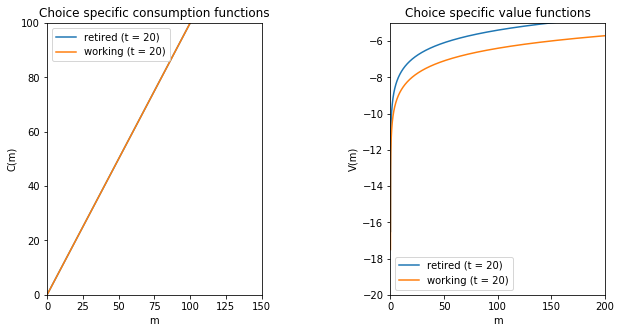

In [10]:
# Terminal solution

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)
#model.timeRev()
t=20
Tmtm1 = T
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0, 150))
plt.ylim((0, 100))

plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0, 200))
plt.ylim((-20, -5))

Since work is paid at the beginning of the period after it takes place, it is never optimal to work in the last period. The wage would be lost (as the agent dies after this ultimate period), there is disutility of work in the model, and there is no bequest motive.

Let us now consider the second to last period.

(-30, -10)

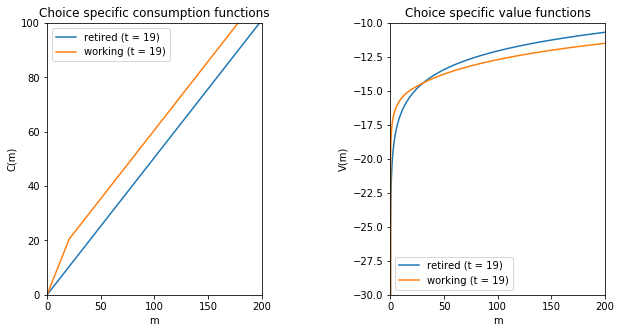

In [11]:
# Time T-1

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

t=19
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0,200))
plt.ylim((0,100))
plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0,200))
plt.ylim((-30,-10))

The panel on the left shows the consumption functions conditional on working or retiring given the beginning of period resources $m$. We recognize the usual solutions from standard consumption savings models. The worker has a segment (for low $m$) where they consume everything, and the retiree smoothes consumption over current and next period. The two functions are different because retired agents don't earn *any* income in this model, and the workers are constrained for low $m$ because they would prefer to borrow money today if they could because they *do* earn an income (of 20) between two periods.

In the second-to-last period, we begin to see where problems might arise. Since the agent will want to work for low values of $m$ and retire for high values of $m$, the value function will have *kinks* and the consumption function will have discontinuities. This will happen where the two choice specific value functions cross. A crossing like that will create a point of nondifferentiability in the value function. Discontinuities and non-differentiable points are unwanted quite generally, because local optima are no longer global optima. In other words, the first order conditions are necessary for interior solutions, but no longer sufficient.

Below, we see the result of calculating the upper envelope of the value functions and the consumption function that follows.

(-1, 200)

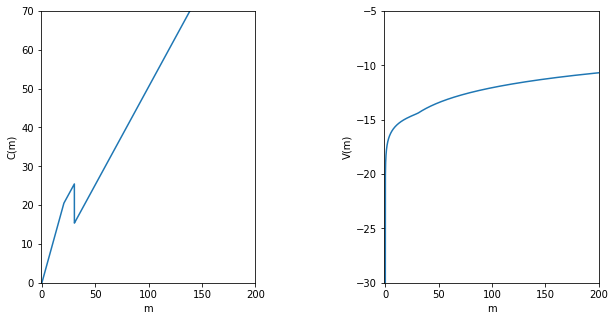

In [12]:
# Upper Envelope and consumption functions

t = 19
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1,2,1)
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((-1, 200))
plt.ylim((0, 70))

plt.subplot(1,2,2)
plt.plot(model.mGrid, numpy.divide(-1.0, model.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
plt.ylim((-30, -5))
plt.xlim((-1, 200))

It should now be clear that simply applying an EGM step at $t=18$ will be problematic, as it is now possible that the value function has the same derivative for different values of $m$.

Let's go back one period.
It's important to keep in mind that seen from period $t=18$, we have to take
into consideration that varying consumption today may change the wealth tomorrow
in such a way that the optimal decision flips from retirement to work (and the
other way around). Let's plot it the panels for t=18.

(-30, -10)

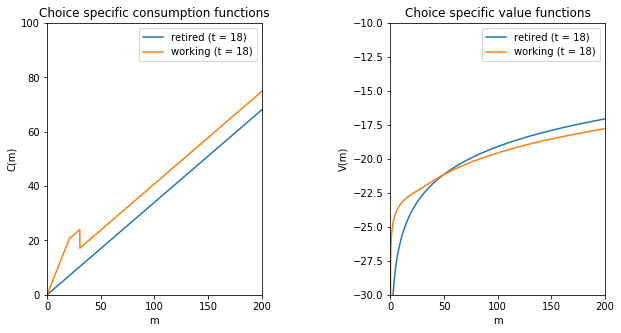

In [13]:
# One more period

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

t=18
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0,200))
plt.ylim((0,100))
plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0,200))
plt.ylim((-30,-10))

This time we see a discontinuity already in the choice specific consumption
function and kinks in the choice specific value functions for the workers!
This is *not* the discontinuity from the retirement threshold in period $t=18$,
but from the "future" switch in discrete choice from work to retire in $t=19$. Let's take a look at the upper envelope and the consumption function it implies.

(-1, 200)

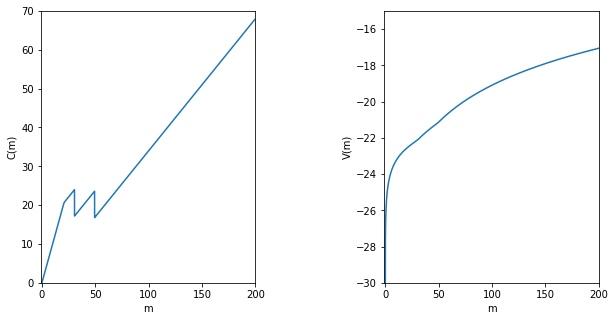

In [14]:
# Discontinuity propagating

t = 18
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1,2,1)
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((-1, 200))
plt.ylim((0, 70))

plt.subplot(1,2,2)
plt.plot(model.mGrid, numpy.divide(-1.0, model.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
plt.ylim((-30, -15))
plt.xlim((-1, 200))

We once again see a primary kink and discontinuity, but we also see the the
effect of the retirement behavior at period $t=19$. These are called secondary
kinks. As is maybe clear by now, each period will introduce a new primary kink, that
will propogate back through the recursion and become secondary kinks in earlier
periods. Let's finish off by looking at $t=1$

(-250, -100)

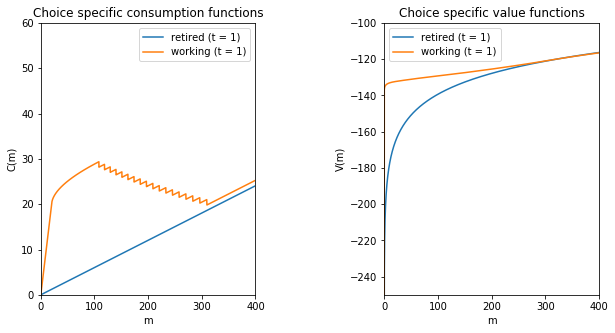

In [15]:
# Recursion hurts

f, axs = plt.subplots(2,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

t=1
plt.subplot(1,2,1)
model.plotC(t, 1)
model.plotC(t, 2)
plt.xlim((0, 400))
plt.ylim((0, 60))

plt.subplot(1,2,2)
model.plotV(t, 1)
model.plotV(t, 2)
plt.xlim((0, 400))
plt.ylim((-250, -100))

and

(-5, 500)

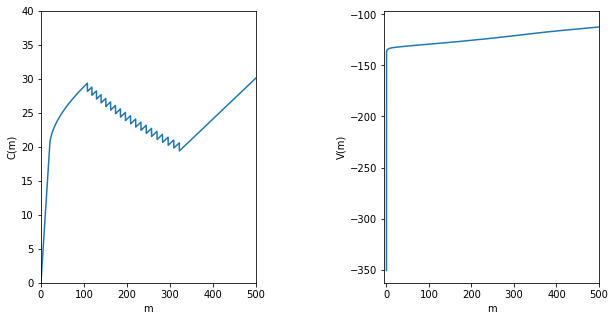

In [16]:
# All the way back

t = 1
f, axs = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.6)

plt.subplot(1,2,1)
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((0, 500))
plt.ylim((0, 40))

plt.subplot(1,2,2)
plt.plot(model.mGrid, numpy.divide(-1.0, model.solution[t].V_T))
plt.xlabel("m")
plt.ylabel("V(m)")
plt.xlim((-5, 500))


Hopefully, it's clear that a specialized method is necessary to produce such accurate solutions, and that is exactly what the DCEGM algorithm that is implemented in HARK is an example of.

# Income uncertainty
Above we saw that the optimal consumption is very jagged: individuals can completely predict their future income given the current and future choices, so they can precisely time their optimal retirement already from "birth". We will now see how adding income uncertainty can smooth out some of these discontinuities: Note, the behavior above certainly was rational and optimal, the model just wasn't too realistic. Most modern consumption/saving models will include at least transitory shocks, permanent shocks, or both.

Instead of simply having a constant income, given the lagged work/retire decision, we introduce a multiplicative, transitory income shock that is lognormally distributed, and has mean 1. This means that the mean income for a worker is still 20.

To set a positive variance we specify the standard deviation, $\sigma$, and the number of nodes used to do evaluate the expectations. We set $\sigma=\sqrt{0.005}$ to replicate the results in Figure 4 in the paper.

In [17]:
# Define shocks

incshk_params = copy.deepcopy(retiring_params)
incshk_params['Rfree'] = 1.0
incshk_params['DiscFac'] = 0.98
incshk_params['TranShkCount'] = 100
incshk_params['TranShkStd'] = [sqrt(0.005)]*incshk_params['T']
modelTranInc = RetiringDeaton(**incshk_params)
modelTranInc.solve()

(15, 25)

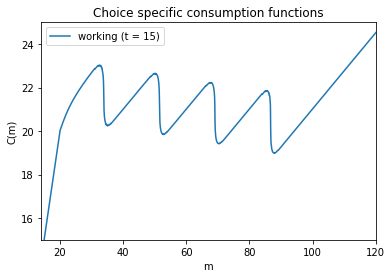

In [18]:
# Five periods before end

t = 15

modelTranInc.plotC(t, 2)
plt.xlim((14,120))
plt.ylim((15,25))


From this, we see that the secondary kinks, that is the kinks that come from expected future retirement choices, are smoothed out, because the agent cannot completely foresee and plan the retirement. A small transitory shock might delay retirement, and a big transitory shock might advance retirement. However, the primary kinks will still be "hard" discontinuities as we have not yet introduced taste shocks. The "ex ante" consumption function is plotted below.

(0, 40)

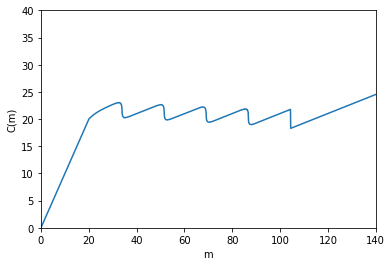

In [19]:
# Ex-ante consumption function

t = 15

plt.plot(modelTranInc.mGrid, modelTranInc.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((0, 140))
plt.ylim((0, 40))

# Replication of figures from <cite data-cite="6202365/4F64GG8F"></cite>

Below, we present figures that replicate some of the results in the paper we're replicating. Note, that there are some typos in the original paper that we're taking into consideration. We thank Thomas Jørgensen for providing us with the scripts to produce the figures in the text to verify these issues. We'll point out the issues as we present the figures.

## Figure 2

Figure 2 in the paper shows the quality of the solution against a closed form solution of the model. We have not implemented the closed form solution here, but we present the solution for the same time periods regardless. It should be clear by comparing the two, that the solutions are indeed identical.

Note, that the figure text in the paper says that these are the consumption choice conditional on the choice of working, but this is *not* the case. This is instead the "ex ante" consumption function, or the function that answers the question: "If we've *just* entered the period with $m$ resources, what is the consumption when we take the optimal discrete choice into consideration?". For example, the consumption function for the workers in period 18 does *not* have two discontinuities. It has one. The second discontinuity shown here is represents the current period threshold of switching from working to retiring.

(0, 40)

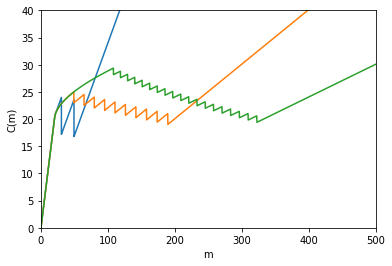

In [20]:
# Figures from the paper

fig2_params = copy.deepcopy(retiring_params)
fig2_params['Rfree'] = 1.0
fig2_params['DiscFac'] = 0.98
model_fig2 = RetiringDeaton(**retiring_params)
model_fig2.solve()
t = 18
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
t = 10
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((0, 500))
plt.ylim((0, 40))
t = 1
plt.plot(model.mGrid, model.solution[t].C)
plt.xlabel("m")
plt.ylabel("C(m)")
plt.xlim((0, 500))
plt.ylim((0, 40))

## Figure 3
Figure 3 in the paper shows how the agent attempts to smooth its consumption over the life time, while taking into consideration the retirement age. The perfect smoothing results because we have a parameterization of $DiscFac=1/Rfree$. There are no shocks of any kind, so this can be perfectly planned.

The paper mentiones a risk-free discount factor of $Rfree=1.02$, but actually, it is $Rfree=1.01$ as evident in the scripts that's been provided for us. 

(0, 40)

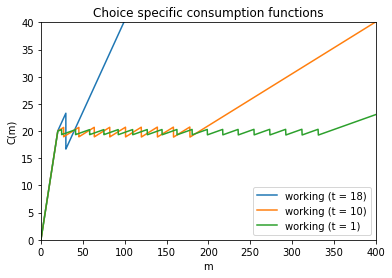

In [21]:
# Smoothing is not very smooth

fig3_params = retiring_params.copy()
fig3_params['Rfree'] = 1.01
fig3_params['DiscFac'] = 1/fig3_params['Rfree']
model_fig3 = RetiringDeaton(**fig3_params)
model_fig3.solve()
t = 18
model_fig3.plotC(t, 2)
t = 10
model_fig3.plotC(t, 2)
t = 1
model_fig3.plotC(t, 2)


plt.xlim((0,400))
plt.ylim((0,40))

## Figure 4
Figure 4 shows how adding a taste shock can significantly smoothen the model. The positive take-away is that we can get away with smoothing very little if we just want to avoid actual discontinuities, and turn them into sharp drops. The negative take-away is of course that as the scale factor $\sigma$ increases, the model starts to resemble the original model less and less.

(15, 25)

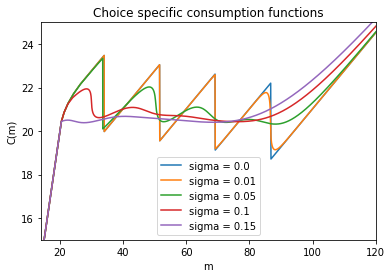

In [22]:
# Adding "taste shocks"

fig4_1_params = copy.deepcopy(retiring_params)
fig4_1_params['Rfree'] = 1.0
fig4_1_params['DiscFac'] = 0.98
fig4_1_params['TranShkCount'] = 1
fig4_1_params['TranShkStd'] = [sqrt(0.0000)]*fig4_1_params['T']
modelfig4_1 = RetiringDeaton(**fig4_1_params)
modelfig4_1.solve()

fig4_2_params = copy.deepcopy(fig4_1_params)
fig4_2_params['sigma'] = 0.01
modelfig4_2 = RetiringDeaton(**fig4_2_params)
modelfig4_2.solve()

fig4_3_params = copy.deepcopy(fig4_1_params)
fig4_3_params['sigma'] = 0.05
modelfig4_3 = RetiringDeaton(**fig4_3_params)
modelfig4_3.solve()

fig4_4_params = copy.deepcopy(fig4_1_params)
fig4_4_params['sigma'] = 0.1
modelfig4_4 = RetiringDeaton(**fig4_4_params)
modelfig4_4.solve()

fig4_5_params = copy.deepcopy(fig4_1_params)
fig4_5_params['sigma'] = 0.15
modelfig4_5 = RetiringDeaton(**fig4_5_params)
modelfig4_5.solve()


t = 15
for mfig in (modelfig4_1, modelfig4_2, modelfig4_3, modelfig4_4, modelfig4_5):
    mfig.plotC(t, 2, label="sigma = {}".format(mfig.sigma))
plt.xlim((14,120))
plt.ylim((15,25))

# References
<div class="cite2c-biblio"></div>
<cite data-cite="6202365/4F64GG8F"></cite>